# Sequence to Sequence (seq2seq) Recurrent Neural Network (RNN) for Time Series Prediction

In time series prediction, the goal is to predict the future values based on past observation which consists of intrinsic patterns. To determine a model that expresses the pattern of the time series, we need a model to describe the important features of the time series pattern and explain how the past affects the future or how two-time series can “interact”.  In this project, I want to predict the future value of Bitcoin using Stack GRU\LSTM and Sequence to Sequence model (Seq2Seq) which is introduced in http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf as a learning method for natural language processing. 
In this notebook, I inspired by two notebooks:\\
* ["Sequence to Sequence (seq2seq) Recurrent Neural Network (RNN) for Time Series Prediction"](https://github.com/guillaume-chevalier/seq2seq-signal-prediction) by Guillaume Chevalier.
* ["An implementation of a sequence to sequence neural network using an encoder-decoder"](https://github.com/LukeTonin/keras-seq-2-seq-signal-prediction) by Luck Tonin

Based on my result the Seq2Seq has a better performance in compare of Stack LSTM in terms of MAPE error. You can check this notebook for Seq2Seq model and "Udacity-Capstone-StackLSTM" for the other model. 

## How to use this ".ipynb" Python notebook ?

To run the notebook, you must have installed Jupyter Notebook or iPython Notebook. To open the notebook, you must write `jupyter notebook` or `iPython notebook` in command line (from the folder containing the notebook once downloaded, or a parent folder). It is then that the notebook application (IDE) will open in your browser as a local server and it will be possible to open the `.ipynb` notebook file and to run code cells with `CTRL+ENTER` and `SHIFT+ENTER`, it is also possible to restart the kernel and run all cells at once with the menus. Note that this is interesting since it is possible to make that IDE run as hosted on a cloud server with a lot of GPU power while you code through the browser.


## Problem Statment

This project is created to predict the future value of the Bitcoin's price. The data that we used is the daily market data of the bitcoin's value, consits of BTC/USD and BTC/EUR. The goal of this project is to predict one week of bitcoin price using Seq2Seq network. We can imporve the result by adding more data for example the stock market data.

## Data Set and Input of Network
I created a python code to read the dataset and convert it into past and future window and also batch the data in "utils_Bitcoin.py". I imported the generator function from this dataset as "generate_x_y_data". The inputs of this generator are "Status" can be "Train", "Validation" or "Test". Other inputs are "batch_size", "past_window", and "future_window" which are the size of the batch, how much data in the past we use to slide the data, and how many steps we will predict in future, respectively.  

In the "utils_Bitcoin.py" file, first I read the data from http://api.coindesk.com/v1/bpi/historical/close.json?start=2010-07-17&end=2017-03-03 
and then concatanate the both value of bitcoin in terms of "USD" and "EUR". Next, I window the data based on the past_window and future_window. After that, I normalized the data and passed it to the "fetch_batch_size_random" to creat and select the bathc of the data. 


In [1]:
from utils_Bitcoin import generate_x_y_data

In [2]:

import tensorflow as tf  # Version 1.0 or 0.12
import numpy as np
import matplotlib.pyplot as plt

# This is for the notebook to generate inline matplotlib 
# charts rather than to open a new window every time: 
%matplotlib inline


## Neural network's hyperparameters

In [3]:
past_window = 7
future_window = 7
sample_x, sample_y = generate_x_y_data(Status = "Train", batch_size=16,  past_window = past_window, future_window=future_window)
print("Dimensions of the dataset for 3 X and 3 Y training examples : ")
print(sample_x.shape)
print(sample_y.shape)
print("(seq_length, batch_size, output_dim)")

# Internal neural network parameters
seq_length = sample_x.shape[0]  # Time series will have the same past and future (to be predicted) lenght. 
batch_size = 100  # Low value used for live demo purposes - 100 and 1000 would be possible too, crank that up!

output_dim = input_dim = sample_x.shape[-1]  # Output dimension (e.g.: multiple signals at once, tied in time)
hidden_dim = 100 # Count of hidden neurons in the recurrent units. 
layers_stacked_count = 2  # Number of stacked recurrent cells, on the neural depth axis. 

# Optmizer: 
learning_rate = 0.007  # Small lr helps not to diverge during training. 
steps_per_batch =14 # How many times in each iteration we train
nb_iters = 100  # How many times we perform a training step (therefore how many times we show a batch). 
lr_decay = 0.92  # default: 0.9 . Simulated annealing.
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting
regulariser = None # Possible regulariser: keras.regularizers.l2(lambda_regulariser)

Dimensions of the dataset for 3 X and 3 Y training examples : 
(7, 16, 2)
(7, 16, 2)
(seq_length, batch_size, output_dim)


## Definition of the seq2seq neuronal architecture

<img src="https://www.tensorflow.org/images/basic_seq2seq.png" />

Comparatively to what we see in the image, our neural network deals with signal rather than letters. Also, we don't have the feedback mechanism yet. 

In [4]:

# Backward compatibility for TensorFlow's version 0.12: 
try:
    tf.nn.seq2seq = tf.contrib.legacy_seq2seq
    tf.nn.rnn_cell = tf.contrib.rnn
    tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell
    print("TensorFlow's version : 1.0 (or more)")
except: 
    print("TensorFlow's version : 0.12")


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

TensorFlow's version : 1.0 (or more)


## Define the network architecture 
### Encoder and decoder 

In [5]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
#PlaceHolders:
input_time_series = tf.placeholder("float", [None, None, input_dim])
# Decoder: expected outputs:
expected_output = tf.placeholder("float", [None, None, output_dim])
# Input of encoder:
enc_inp = tf.unstack(input_time_series, seq_length, 0)
dec_inp = tf.zeros_like(expected_output, dtype=np.float32)  
""" Defining the network:"""
# Encoder Cell:
encoder_cell = []
for i in range(layers_stacked_count):
    encoder_cell.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
encoder_MultiRNN = tf.nn.rnn_cell.MultiRNNCell(encoder_cell, state_is_tuple=False)
intial_enc_state = encoder_MultiRNN.zero_state(batch_size,tf.float32)
print(intial_enc_state)
encoder_outputs, encoder_states = tf.nn.dynamic_rnn(encoder_MultiRNN, input_time_series, initial_state=intial_enc_state,
                                                    dtype=tf.float32, time_major=True)

# Sample from encoder states:
num_mu = int(hidden_dim*layers_stacked_count/2)
enc_mu, enc_rho = encoder_states[:, :num_mu], encoder_states[:, num_mu:]
encoding = ds.NormalWithSoftplusScale(enc_mu, enc_rho - 5)
# Decoder Cell:
#decoder_cell = []
#decoder_cell.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
#decoder_MultiRNN = tf.nn.rnn_cell.MultiRNNCell(decoder_cell, state_is_tuple=False)
decoder_outputs, decoder_states = tf.nn.dynamic_rnn(encoder_MultiRNN, dec_inp, initial_state=encoder_states, 
                                                    dtype=tf.float32, time_major=True)

decoder_dense = tf.keras.layers.Dense(output_dim,
                                   activation='linear',
                                   kernel_regularizer=regulariser,
                                   bias_regularizer=regulariser)

decoder_outputs = decoder_dense(decoder_outputs)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Tensor("MultiRNNCellZeroState/MultiRNNCellZeroState/zeros:0", shape=(100, 200), dtype=float32)
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argum

In [6]:
# Define the loss function and Metrics

import math

total_loss = tf.reduce_mean(tf.keras.losses.MSE(decoder_outputs, expected_output))


with tf.variable_scope('Optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(total_loss)
"""
Metrics used to measure the performance of a model:
100%/N \Sigma_{n=1}^N |(y_pred - y_true)/y_true|
import math
""" 
MAPE =(1/batch_size)*tf.reduce_mean(tf.abs(decoder_outputs- expected_output)/expected_output)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [7]:
# Training
def train_batch(batch_size):
    """
    Training step that optimizes the weights 
    provided some batch_size X and Y examples from the dataset. 
    """
    X, Y = generate_x_y_data(Status="Train", batch_size=batch_size, past_window = past_window, future_window=future_window)
    feed_dict = {input_time_series: X}
    feed_dict.update({expected_output: Y})
    _, loss_t = sess.run([train_op, total_loss], feed_dict)
    return loss_t

def test_batch(batch_size):
    """
    Test step, does NOT optimizes. Weights are frozen by not
    doing sess.run on the train_op. 
    """
    X, Y  = generate_x_y_data(Status="Validation",batch_size=batch_size, past_window = past_window, future_window=future_window)
    loss_t, test_output = sess.run([total_loss, decoder_outputs], feed_dict= {input_time_series: X, expected_output: Y})
    return loss_t, test_output

def evaluate():
    X, Y  = generate_x_y_data(Status="Train", batch_size=batch_size, past_window = past_window, future_window=future_window)
    acc = sess.run([MAPE], feed_dict= {input_time_series: X, expected_output: Y})
    return acc

In [8]:
# Training
train_losses = []
test_losses = []
test_outputs = []
accuracy_eval = []

sess.run(tf.global_variables_initializer())
for t in range(nb_iters+1):
    for i in range(steps_per_batch):
        train_loss = train_batch(batch_size)
        train_losses.append(train_loss)
        test_loss, test_output = test_batch(batch_size)
        test_losses.append(test_loss)
        test_outputs.append(test_output)
        acc = evaluate()
        accuracy_eval.append(acc)
    if t % 10 == 0: 
        # Tester

        print("Step {}/{}, train loss: {}, \tTEST loss: {}, \taccuracy:{}"
              .format(t, nb_iters, train_loss, test_loss, *evaluate()))

print("Fin. train loss: {}, \tTEST loss: {}, \taccuracy:{}"
      .format(train_loss, test_loss, *evaluate()))

Step 0/100, train loss: 3.2540359497070312, 	TEST loss: 4.127311706542969, 	accuracy:-0.06309015303850174
Step 10/100, train loss: 4.2464704513549805, 	TEST loss: 6.8612961769104, 	accuracy:0.023101193830370903
Step 20/100, train loss: 2.9492249488830566, 	TEST loss: 9.531795501708984, 	accuracy:0.0029581685084849596
Step 30/100, train loss: 3.547639846801758, 	TEST loss: 4.780705451965332, 	accuracy:-0.017382940277457237
Step 40/100, train loss: 2.6778459548950195, 	TEST loss: 9.553925514221191, 	accuracy:-0.004392465576529503
Step 50/100, train loss: 2.3806023597717285, 	TEST loss: 8.00051498413086, 	accuracy:-0.000994409783743322
Step 60/100, train loss: 1.722172737121582, 	TEST loss: 6.656540393829346, 	accuracy:0.07314237207174301
Step 70/100, train loss: 1.853244662284851, 	TEST loss: 10.838922500610352, 	accuracy:-0.026657888665795326
Step 80/100, train loss: 2.302605152130127, 	TEST loss: 13.389769554138184, 	accuracy:-0.004823493771255016
Step 90/100, train loss: 1.34739470481

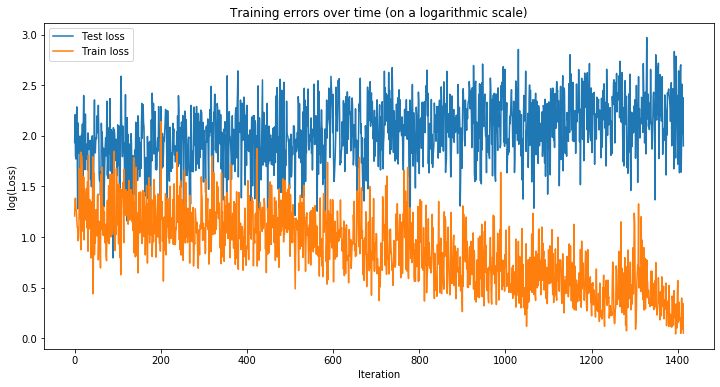

In [9]:
# Plot loss over time:
plt.figure(figsize=(12, 6))
plt.plot(
    np.array(range(0, len(test_losses)))/float(len(test_losses)-1)*(len(train_losses)-1), 
    np.log(test_losses), 
    label="Test loss"
)
plt.plot(
    np.log(train_losses), 
    label="Train loss"
)
plt.title("Training errors over time (on a logarithmic scale)")
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.legend(loc='best')
plt.show()

Let's visualize 5 predictions with our signals:
[0.010308595]


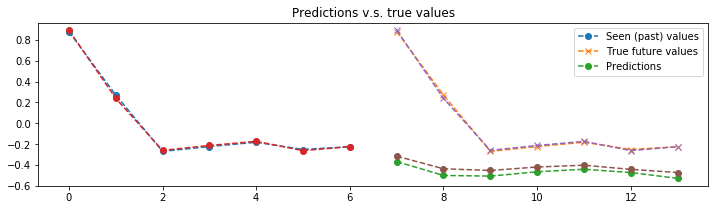

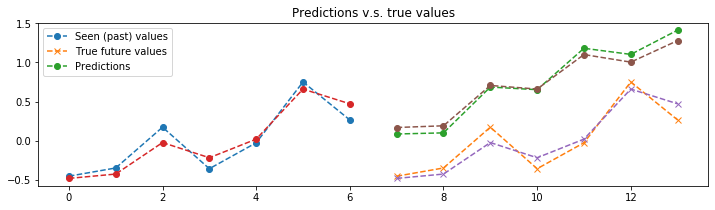

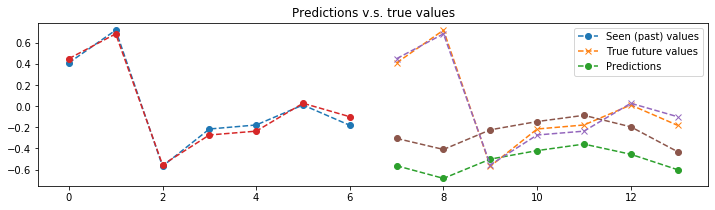

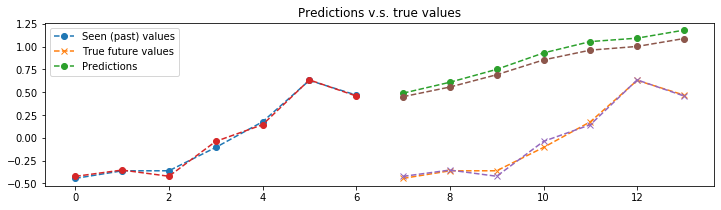

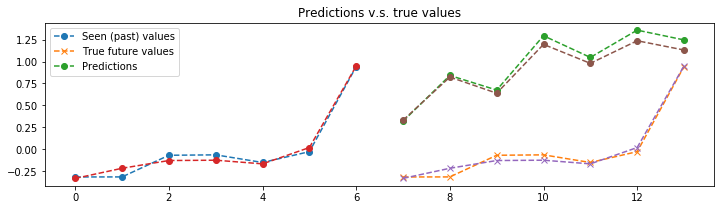

In [10]:
# Evaluate the model with test part of the data by visualizing the prediction for number of test:
number_of_test = 5
print("Let's visualize {} predictions with our signals:".format(number_of_test))

X, Y = generate_x_y_data(Status="Test", batch_size=batch_size, past_window = past_window, future_window=future_window)
feed_dict = {input_time_series: X}
feed_dict.update({expected_output: Y})
outputs = np.array(sess.run([decoder_outputs], feed_dict)[0])
acc = sess.run([MAPE], feed_dict= {input_time_series: X, expected_output: Y})
print(acc)

for j in range(number_of_test): 
    plt.figure(figsize=(12, 3))
    
    for k in range(output_dim):
        past = X[:,j,k]
        expected = Y[:,j,k]
        pred = outputs[:,j,k]
        label1 = "Seen (past) values" if k==0 else "_nolegend_"
        label2 = "True future values" if k==0 else "_nolegend_"
        label3 = "Predictions" if k==0 else "_nolegend_"
        plt.plot(range(len(past)), past, "o--", label=label1)
        plt.plot(range(len(past), len(expected)+len(past)), expected, "x--", label=label2)
        plt.plot(range(len(past), len(pred)+len(past)), pred, "o--", label=label3)
    
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()

## Result
In result, I got 1.0% as the average of MAPE, which is better than other methods. and it can follows the trend of Bitcoin values. 

I can imporve this result by adding more features or change the hyperparameters.This problem was a really chalanging problem and it tooks too much to fit this model. 